<a href="https://colab.research.google.com/github/tjaustria4/CoE197Z-Deep-Learrning-Completion-Project_201505476/blob/main/CoE197Z_Deep_Learning_Completion_Project_201505476.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CoE 197Z - Deep Learning Completion Project**

---


Theodore J. Austria

2015-05476

---



The main code that was used here was from the site: *https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html* by the author **Sasank Chilamkurthy**.

I added my code for preparing the data to be fed into the model. I modified some of the code to fit for the required task. The format 2 of the SVHN core was used in this code.






In [1]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from PIL import Image
import scipy.io as sio

I uploaded the format 2 data set which is the .mat files into my google drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Checked for the list of models.

In [ ]:
[model for model in dir(models)]

I loaded the two .mat files(format 2 of the SVHN core) using the scipy.io library.

Based from what I have researched and learned from the resources online, the structure of the root folder for the data set must be in the form:

    root/
      train/
        labels/
          image1.jpg
          ...
      val/
        labels/
          image2.jpg
          ...
The code below extracts the information from the .mat files which are:


*   images with size 32x32
*   corresponding label of the image









    

In [6]:
# load .mat files
train = sio.loadmat('/content/drive/MyDrive/train_32x32.mat')
val = sio.loadmat('/content/drive/MyDrive/test_32x32.mat')

# access to the dict
x_train = train['X'] #images
y_train = train['y'] #labels of the train images
print('train len: '+ str(len(y_train)))
x_val = val['X'] #images
y_val = val['y'] #labels of the val images
print('val len: '+ str(len(y_val)))

train len: 73257
val len: 26032


Because of the structure of the root folder and the information of the .mat files, the code below saves the 32x32 pictures to the drive with the following details:

*   Root folder = "SVHN_cropped"
*   Labels/Sub-folders of the train folder = "1" ,"2",...,"10"
  *   Contents are the images of the "train_32x32.mat" file

*   Labels/Sub-folders of the val folder = "1" ,"2",...,"10"
  *   Contents are the images of the "test_32x32.mat" file

In [7]:
# save the images to the train folder with the labels subfolders
number_of_files = 0
for number_of_files in range(73256):
  im = Image.fromarray(x_train[:,:,:,number_of_files])
  im.save('/content/drive/MyDrive/SVHN_cropped/train/'+str(int(y_train[number_of_files])) + '/' +str(number_of_files+1) + '.jpg')

number_of_files = 0
# save the images to the val folder with the labels subfolders
for number_of_files in range(26031):
  im = Image.fromarray(x_val[:,:,:,number_of_files])
  im.save('/content/drive/MyDrive/SVHN_cropped/val/'+str(int(y_val[number_of_files])) + '/' +str(number_of_files+1) + '.jpg')

Check if the files are correct by looking at the number of files in the train and val folder if they match with the .mat labels length.

In [ ]:
number_files = 0
for numlabel in range(10):
  list = os.listdir('/content/drive/MyDrive/SVHN_cropped/val/' + str(numlabel + 1))
  number_files = number_files + len(list)
  print(len(list))
print(number_files)
number_files = 0

The code below is for the preprocessing of the data. This will create the dataloader to be fed to the model. Data is fetched from the path of the folder "SVHN_cropped".

In [11]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/SVHN_cropped'
#data_dir = '/content/drive/MyDrive/SVHN_small'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=1024, shuffle=True, num_workers=2) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Check for the device if cuda or cpu.

In [ ]:
print(device)

Check the details of the nvidia cuda.

In [ ]:
!nvidia-smi

Check if cuda is available.

In [ ]:
torch.cuda.is_available()

Check what GPU is used.

In [ ]:
torch.cuda.get_device_name(0)

The code below shows some of the images and their corresponding labels.

The number of images depends on the batch_size.

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

The code below is for the training of the model. 

The number of epochs that I set was 25. 

Throughout the training process, the loss and acc values are shown per epoch. As the epoch further progresses, loss is decreased and acc is increased. This can be shown by the plots.

After the model is trained, the plots of the train loss, train acc, val loss, and val acc are shown.



In [17]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    train_array_loss = []
    train_array_acc = []
    val_array_loss = []
    val_array_acc = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            #get details for plot
            if phase == 'train':
                train_array_loss.append(epoch_loss)
                train_array_acc.append(epoch_acc)
            if phase == 'val':
                val_array_loss.append(epoch_loss)
                val_array_acc.append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    # Print the plots of the loss and acc values for train and val
    #plt.subplot(1,2,1)
    plt.plot(train_array_loss, label = 'Train Loss')
    plt.plot(train_array_acc, label = 'Train Acc')
    plt.legend()
    plt.title('Train data loss and acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()
    #plt.subplot(1,2,2)
    plt.plot(val_array_loss, label = 'Val Loss')
    plt.plot(val_array_acc, label = 'Val Acc')
    plt.legend()
    plt.title('Val data loss and acc')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
  

    return model

The function below is for visualization purposes. We can see here the image and the predicted number of that image.

In [18]:
def visualize_model(model, num_images=10):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Training of the three models**

---
The models used are:

*   resnet18
*   wide_resnet50_2
*   resnext50_32x4d

The models were trained with:

*   batch size = 1024
*   epoch = 25

The plots for the train loss/accuracy and val loss/accuracy are shown after the 25 epochs are completed.

# **resnet18 model**

In [20]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training resnet18 model..
Epoch 0/24
----------
train Loss: 2.0310 Acc: 0.2919
val Loss: 1.6278 Acc: 0.4386

Epoch 1/24
----------
train Loss: 1.3845 Acc: 0.5265
val Loss: 1.1447 Acc: 0.6105

Epoch 2/24
----------
train Loss: 0.9883 Acc: 0.6641
val Loss: 0.8819 Acc: 0.7049

Epoch 3/24
----------
train Loss: 0.7724 Acc: 0.7387
val Loss: 0.7402 Acc: 0.7541

Epoch 4/24
----------
train Loss: 0.6411 Acc: 0.7863
val Loss: 0.6468 Acc: 0.7888

Epoch 5/24
----------
train Loss: 0.5530 Acc: 0.8165
val Loss: 0.5894 Acc: 0.8103

Epoch 6/24
----------
train Loss: 0.4881 Acc: 0.8392
val Loss: 0.5480 Acc: 0.8251

Epoch 7/24
----------
train Loss: 0.4432 Acc: 0.8556
val Loss: 0.5410 Acc: 0.8271

Epoch 8/24
----------
train Loss: 0.4383 Acc: 0.8572
val Loss: 0.5400 Acc: 0.8267

Epoch 9/24
----------
train Loss: 0.4337 Acc: 0.8590
val Loss: 0.5370 Acc: 0.8279

Epoch 10/24
----------
train Loss: 0.4295 Acc: 0.8602
val Loss: 0.5338 Acc: 0.8297

Epoch 11/24
----------
train Loss: 0.4240 Acc: 0.8614
val Lo

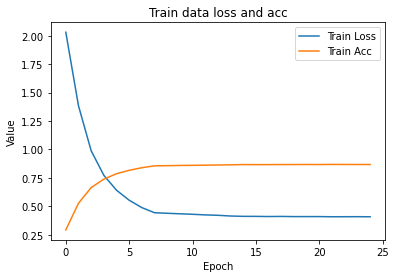

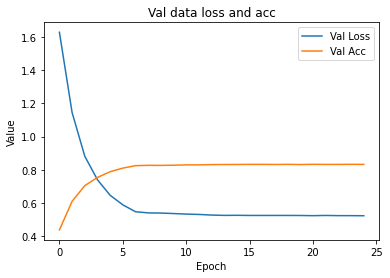

Training complete in 39m 7s
Best val Acc: 0.833160


In [21]:
print('Training resnet18 model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

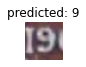

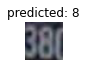

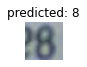

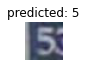

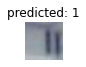

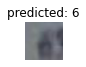

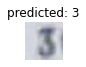

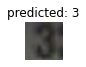

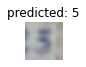

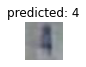

In [24]:
visualize_model(model_ft)

# **wide_resnet50_2 model**

In [28]:
model_ft = models.wide_resnet50_2(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training wide_resnet50_2 model..
Epoch 0/24
----------
train Loss: 2.1918 Acc: 0.2082
val Loss: 2.0127 Acc: 0.2832

Epoch 1/24
----------
train Loss: 1.7610 Acc: 0.3962
val Loss: 1.5461 Acc: 0.4789

Epoch 2/24
----------
train Loss: 1.2734 Acc: 0.5810
val Loss: 1.1420 Acc: 0.6155

Epoch 3/24
----------
train Loss: 0.8920 Acc: 0.7053
val Loss: 0.9208 Acc: 0.6941

Epoch 4/24
----------
train Loss: 0.6333 Acc: 0.7940
val Loss: 0.8152 Acc: 0.7367

Epoch 5/24
----------
train Loss: 0.4522 Acc: 0.8582
val Loss: 0.7720 Acc: 0.7563

Epoch 6/24
----------
train Loss: 0.3191 Acc: 0.9063
val Loss: 0.7592 Acc: 0.7661

Epoch 7/24
----------
train Loss: 0.2283 Acc: 0.9443
val Loss: 0.7617 Acc: 0.7674

Epoch 8/24
----------
train Loss: 0.2165 Acc: 0.9479
val Loss: 0.7656 Acc: 0.7668

Epoch 9/24
----------
train Loss: 0.2064 Acc: 0.9521
val Loss: 0.7631 Acc: 0.7685

Epoch 10/24
----------
train Loss: 0.1967 Acc: 0.9547
val Loss: 0.7630 Acc: 0.7684

Epoch 11/24
----------
train Loss: 0.1889 Acc: 0.9574

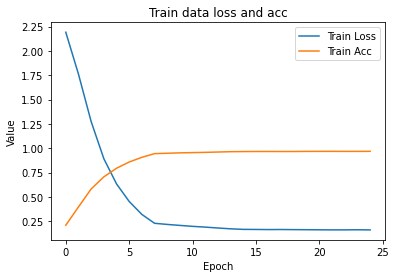

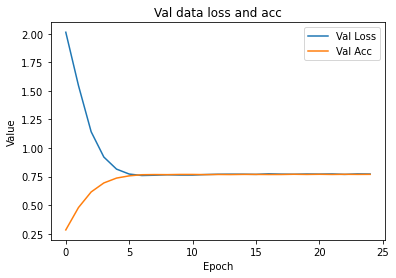

Training complete in 91m 9s
Best val Acc: 0.770005


In [29]:
print('Training wide_resnet50_2 model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

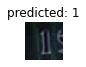

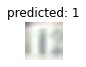

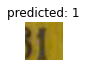

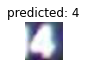

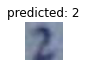

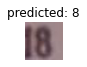

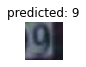

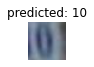

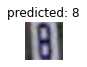

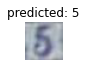

In [36]:
visualize_model(model_ft)

# **resnext50_32x4d model**

In [43]:
model_ft = models.resnext50_32x4d(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Training resnext50_32x4d model..
Epoch 0/24
----------
train Loss: 2.0160 Acc: 0.2720
val Loss: 1.6914 Acc: 0.3893

Epoch 1/24
----------
train Loss: 1.4489 Acc: 0.4884
val Loss: 1.1809 Acc: 0.5816

Epoch 2/24
----------
train Loss: 1.0035 Acc: 0.6525
val Loss: 0.8861 Acc: 0.7015

Epoch 3/24
----------
train Loss: 0.7148 Acc: 0.7613
val Loss: 0.7240 Acc: 0.7596

Epoch 4/24
----------
train Loss: 0.5297 Acc: 0.8267
val Loss: 0.6511 Acc: 0.7875

Epoch 5/24
----------
train Loss: 0.4039 Acc: 0.8732
val Loss: 0.6221 Acc: 0.8037

Epoch 6/24
----------
train Loss: 0.3048 Acc: 0.9084
val Loss: 0.6291 Acc: 0.8054

Epoch 7/24
----------
train Loss: 0.2293 Acc: 0.9362
val Loss: 0.6208 Acc: 0.8094

Epoch 8/24
----------
train Loss: 0.2177 Acc: 0.9414
val Loss: 0.6240 Acc: 0.8100

Epoch 9/24
----------
train Loss: 0.2084 Acc: 0.9440
val Loss: 0.6266 Acc: 0.8103

Epoch 10/24
----------
train Loss: 0.2005 Acc: 0.9461
val Loss: 0.6309 Acc: 0.8098

Epoch 11/24
----------
train Loss: 0.1929 Acc: 0.9497

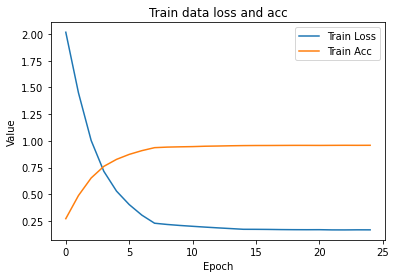

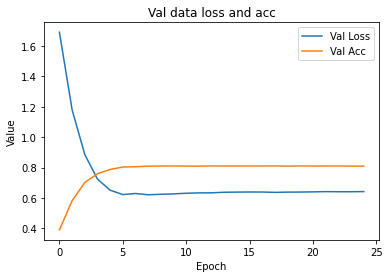

Training complete in 41m 57s
Best val Acc: 0.810995


In [45]:
print('Training resnext50_32x4d model..')
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

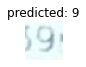

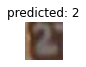

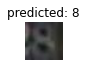

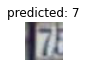

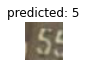

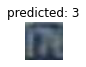

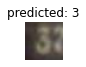

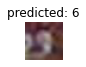

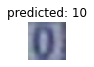

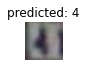

In [49]:
visualize_model(model_ft)